# Part 1 原始趋势策略还原

## 获取数据
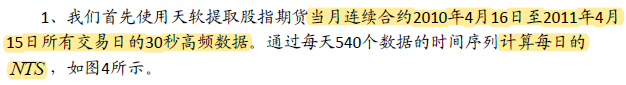

In [1]:
import sys
sys.path.append('../../Utils')

import os 
from data_feed import DataFeed
datafeed = DataFeed(config_path=os.path.join('..', 'config.ini'),
                    local_data_dir='../data')

In [2]:
""" 读取本地数据 """
m1_300 = datafeed.load_local_data('IF8888.CCFX', '1m')
print(m1_300.shape)
m1_300.head()

数据加载完成~ 
first_dt:2010-04-16 09:16:00, 
last_dt:2022-01-28 15:00:00
(729960, 8)


,open,close,high,low,volume,money,date,time
0,3474.055,3495.885,3513.114,3474.055,825.0,865458300.0,2010-04-16,09:16:00
1,3495.017,3492.854,3500.204,3491.814,410.0,430079460.0,2010-04-16,09:17:00
2,3492.132,3490.321,3495.163,3487.942,285.0,298402320.0,2010-04-16,09:18:00
3,3489.075,3473.542,3490.248,3473.317,368.0,384303120.0,2010-04-16,09:19:00
4,3473.573,3476.633,3482.627,3471.577,355.0,370525860.0,2010-04-16,09:20:00


In [3]:
""" 读取本地数据 """
m15_300 = datafeed.load_local_data('IF8888.CCFX', '15m')
print(m15_300.shape)
m15_300.head()

数据加载完成~ 
first_dt:2010-04-16 09:30:00, 
last_dt:2022-01-28 15:00:00
(48664, 8)


,open,close,high,low,volume,money,date,time
0,3474.055,3466.988,3513.114,3458.142,5296.0,5.531420e+09,2010-04-16,09:30:00
1,3467.864,3469.019,3478.529,3463.725,4568.0,4.750250e+09,2010-04-16,09:45:00
2,3469.136,3470.313,3471.154,3461.714,4220.0,4.382473e+09,2010-04-16,10:00:00
3,3470.175,3464.512,3470.712,3461.889,3151.0,3.270559e+09,2010-04-16,10:15:00
4,3464.528,3453.217,3465.486,3450.437,4177.0,4.326711e+09,2010-04-16,10:30:00


## 判断上午走势是否单边

In [4]:
from tqdm import tqdm
import pandas as pd
import numpy as np

### 收益率法-指标计算

In [5]:
def calc_period_ret(mkt_data, period_start, period_end):
    """ 按日顺序计算 """
    final_dfs = []
    sorted_days = sorted(mkt_data['date'].unique())
    for d in tqdm(sorted_days):
        tmp_d_df = mkt_data[mkt_data['date']==d]
        """ 计算Period_Ret """
        tmp_d_df['period_ret'] = None
        period_ret = (tmp_d_df['close'].values[tmp_d_df['time']==period_end]/tmp_d_df['close'].values[tmp_d_df['time']==period_start])[0]-1
        tmp_d_df['period_ret'][tmp_d_df['time']==period_end] = period_ret
        final_dfs.append(tmp_d_df)
    """ 汇总处理后的每日DataFrame """
    mkt_data = pd.concat(final_dfs)
    return mkt_data

### 收益率法-信号计算
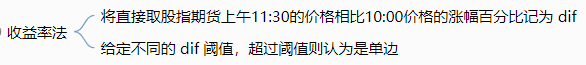

In [6]:
def calc_period_ret_signal(mkt_data, th_level):
    """ 根据th_level，计算持仓signal """
    signal = (mkt_data['period_ret']>th_level).astype(int) - (mkt_data['period_ret']<-th_level).astype(int)
    signal[mkt_data['period_ret'].isnull()] = None
    mkt_data['signal'] = signal
    return mkt_data

#m15_300 = calc_period_ret(m15_300, period_start='10:00:00', period_end='11:30:00')
#m15_300 = calc_period_ret_signal(m15_300, th_level=0.015)
#m15_300.head()

### 多项式拟合法-指标计算
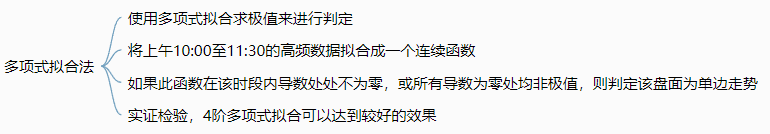

In [7]:
from functools import reduce
#from sympy import *
import sympy

def get_formula(params, x_name='t'):
    t = sympy.symbols('t')
    param_ns = [n for n in range(len(params)-1, -1, -1)]
    formula_items = [p*t**n for p, n in zip(params, param_ns)]
    formula = reduce(lambda x,y: x+y, formula_items)
    return formula, t
    
def calc_period_polyfit_d1_value(mkt_data, period_start, period_end, poly_degree):    
    """ 按日顺序计算 """
    final_dfs = []
    day_idxes = np.hstack([m1_300.drop_duplicates(subset='date').index, len(m1_300)])
    for start_idx, end_idx in zip(tqdm(day_idxes[:-1]), day_idxes[1:]):
        tmp_d_df = mkt_data.iloc[start_idx: end_idx, :].copy()
        """ 将period_start到period_end期间的close序列，按poly_degree进行拟合，并计算dydt """
        # 1. 多项式回归得到params，并通过params生成Formula
        fit_close_s = tmp_d_df[(tmp_d_df['time']>=period_start)&(tmp_d_df['time']<=period_end)]['close']
        params_n = np.polyfit(range(len(fit_close_s)), fit_close_s, poly_degree)
        fit_formula, t = get_formula(params_n, x_name='t')
        # 2. Sympy求Formula的一阶导函数，然后计算全部点下的一阶导结果
        fit_formula_d1 = sympy.diff(fit_formula ,t, 1)
        d1_values = np.array([fit_formula_d1.evalf(subs={t: x}) for x in range(len(fit_close_s))])
        """ 指标赋值 """
        tmp_d_df['fit_formula'], tmp_d_df['fit_formula_d1'], tmp_d_df['t'], tmp_d_df['d1_value'] = None, None, None, None
        tmp_d_df['fit_formula'][(tmp_d_df['time']>=period_start)&(tmp_d_df['time']<=period_end)] = fit_formula
        tmp_d_df['fit_formula_d1'][(tmp_d_df['time']>=period_start)&(tmp_d_df['time']<=period_end)] = fit_formula_d1
        tmp_d_df['t'][(tmp_d_df['time']>=period_start)&(tmp_d_df['time']<=period_end)] = range(len(fit_close_s))
        tmp_d_df['d1_value'][(tmp_d_df['time']>=period_start)&(tmp_d_df['time']<=period_end)] = d1_values
        """ 汇总 """
        final_dfs.append(tmp_d_df)
    """ 拼接汇总后的每日结果DataFrame """
    mkt_data = pd.concat(final_dfs)
    return mkt_data

# m1_300 = calc_period_polyfit_d1_value(m1_300, "10:00:00", "11:30:00", 4)
# m1_300['d1_value'].dropna().shape

### 多项式拟合法-信号计算

In [8]:
def calc_period_polyfit_signal(mkt_data, d1_value_df, period_end):
    final_dfs = []
    for d in tqdm(sorted(d1_value_df['date'].unique())):
        """ 在d1_value_df上进行信号计算 """
        tmp_d1_value_df = d1_value_df[d1_value_df['date']==d]
        d1_values = tmp_d1_value_df['d1_value'].dropna()
        # 若>0，<0的导数值都有，则存在极值，不符合条件；反之则符合，按照一阶导方向进行做多/做空
        signal = ((d1_values>0).sum()>0).astype(int) - ((d1_values<0).sum()>0).astype(int)
        """ 赋值到mkt_data当日的period_end记录上 """
        tmp_mkt_data = mkt_data[mkt_data['date']==d].copy()
        tmp_mkt_data['signal'] = None
        tmp_mkt_data['signal'][tmp_mkt_data['time']==period_end] = signal
        """ 汇总 """
        final_dfs.append(tmp_mkt_data)
    """ 拼接汇总后的每日结果DataFrame """
    mkt_data = pd.concat(final_dfs)
    return mkt_data

# m15_300 = calc_period_polyfit_signal(m15_300, d1_value_df=m1_300, period_end="11:30:00")
# m15_300['signal'].value_counts()

## 计算持仓

In [10]:
def calc_position(mkt_data, shift_period=1, otime_limit=None, etime_limit=None):
    """ signal -> position """
    mkt_data['position'] = mkt_data['signal'].fillna(method='ffill').shift(shift_period).fillna(0)
    """ 是否每天otime前空仓 """
    if otime_limit:
        mkt_data['position'][mkt_data['time']<=otime_limit]=0
    """ 是否每天etime后空仓 """
    if etime_limit:
        mkt_data['position'][mkt_data['time']>etime_limit]=0
    return mkt_data

## 策略表现统计

### 统计函数

In [11]:
def statistic_performance(mkt_data, r0=0.03, data_period=1440, comm=None, leverage=None):
    position = mkt_data['position']
    close = mkt_data['close']
    open_p = mkt_data['open']
    
    d_first = mkt_data['date'].values[0]
    d_last = mkt_data['date'].values[-1]
    d_period = datetime.datetime.strptime(d_last, '%Y-%m-%d') - datetime.datetime.strptime(d_first, '%Y-%m-%d')
    y_period = d_period.days / 365

    """      序列型特征 
        hold_r :      持仓收益
        hold_win :    持仓胜负
        hold_cumu_r : 累计持仓收益
        drawdown :    回撤
        ex_hold_r :   超额收益
    """
    if 'pct_chg' not in mkt_data.columns:
        mkt_data['pct_chg'] = (mkt_data['close']/mkt_data['close'].shift(1)-1) * 100
    hold_r = mkt_data['pct_chg']/100 * position
    # 仓位变化首期的return用close/open-1
    hold_r[abs(position - position.shift(1).fillna(0))>0] = position * (close/open_p-1)
    # 是否考虑换仓成本
    if comm:
        chgpos_comm_perc = (1-comm)**abs(position - position.shift(1).fillna(0)) 
        hold_r = chgpos_comm_perc * (1+hold_r) - 1 
    # 是否有杠杆
    if leverage:
        hold_r *= leverage
    hold_win = hold_r>0
    hold_cumu_r = (1+hold_r).cumprod() - 1
    drawdown = (hold_cumu_r.cummax()-hold_cumu_r)/(1+hold_cumu_r).cummax()    
    ex_hold_r= hold_r-r0/(250*1440/data_period)

    mkt_data['hold_r'] = hold_r
    mkt_data['hold_win'] = hold_win
    mkt_data['hold_cumu_r'] = hold_cumu_r
    mkt_data['drawdown'] = drawdown
    mkt_data['ex_hold_r'] = ex_hold_r
    
    """       数值型特征 
        v_hold_cumu_r：         累计持仓收益
        v_pos_hold_times：      多仓开仓次数
        v_pos_hold_win_times：  多仓开仓盈利次数
        v_pos_hold_period：     多仓持有周期数
        v_pos_hold_win_period： 多仓持有盈利周期数
        v_neg_hold_times：      空仓开仓次数
        v_neg_hold_win_times：  空仓开仓盈利次数
        v_neg_hold_period：     空仓持有盈利周期数
        v_neg_hold_win_period： 空仓开仓次数
        
        v_hold_period：         持仓周期数（最后一笔未平仓订单也算）
        v_hold_win_period：     持仓盈利周期数（最后一笔未平仓订单也算）
        
        v_max_dd：              最大回撤
        v_annual_std：          年化标准差
        v_annual_ret：          年化收益
        v_sharpe：              年化夏普
    """
    v_hold_cumu_r = hold_cumu_r.tolist()[-1]

    v_pos_hold_times= 0 
    v_pos_hold_win_times = 0
    v_pos_hold_period = 0
    v_pos_hold_win_period = 0
    v_neg_hold_times= 0 
    v_neg_hold_win_times = 0
    v_neg_hold_period = 0
    v_neg_hold_win_period = 0
    for w, r, pre_pos, pos in zip(hold_win, hold_r, position.shift(1), position):
        """ 当日有换仓（先结算上一次持仓，再初始化本次持仓） """
        if pre_pos!=pos: 
            # 判断pre_pos非空：若为空则是循环的第一次，此时无需结算，直接初始化持仓即可
            if pre_pos == pre_pos:
                # 结算上一次持仓
                if pre_pos>0:
                    v_pos_hold_times += 1
                    v_pos_hold_period += tmp_hold_period
                    v_pos_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:
                        v_pos_hold_win_times+=1
                elif pre_pos<0:
                    v_neg_hold_times += 1      
                    v_neg_hold_period += tmp_hold_period
                    v_neg_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:                    
                        v_neg_hold_win_times+=1
            # 初始化本次持仓
            tmp_hold_r = r
            tmp_hold_period = 0
            tmp_hold_win_period = 0
        else: 
            if abs(pos)>0:
                tmp_hold_period += 1
                if r>0:
                    tmp_hold_win_period += 1
                if abs(r)>0:
                    tmp_hold_r = (1+tmp_hold_r)*(1+r)-1       

    v_hold_period = (abs(position)>0).sum()
    v_hold_win_period = (hold_r>0).sum()
    v_max_dd = drawdown.max()    
    
    v_annual_ret = (1+v_hold_cumu_r) ** (1/y_period) - 1
    v_annual_std = ex_hold_r.std() * np.sqrt( len(mkt_data)/y_period ) 
    v_sharpe= v_annual_ret / v_annual_std

    """ 生成Performance DataFrame """
    performance_cols = ['累计收益', 
                        '多仓次数', '多仓成功次数', '多仓胜率', '多仓平均持有期', 
                        '空仓次数', '空仓成功次数',  '空仓胜率', '空仓平均持有期', 
                        '日胜率', '最大回撤', '年化收益/最大回撤',
                        '年化收益', '年化标准差', '年化夏普'
                       ]
    performance_values = ['{:.2%}'.format(v_hold_cumu_r),
                          v_pos_hold_times, v_pos_hold_win_times,
                                            '{:.2%}'.format(v_pos_hold_win_times/v_pos_hold_times), 
                                            '{:.2f}'.format(v_pos_hold_period/v_pos_hold_times),
                          v_neg_hold_times, v_neg_hold_win_times,
                                            '{:.2%}'.format(v_neg_hold_win_times/v_neg_hold_times), 
                                            '{:.2f}'.format(v_neg_hold_period/v_neg_hold_times),
                          '{:.2%}'.format(v_hold_win_period/v_hold_period), 
                          '{:.2%}'.format(v_max_dd), 
                          '{:.2f}'.format(v_annual_ret/v_max_dd),
                          '{:.2%}'.format(v_annual_ret), 
                          '{:.2%}'.format(v_annual_std), 
                          '{:.2f}'.format(v_sharpe)
                         ]
    performance_df = pd.DataFrame(performance_values, index=performance_cols)
    
    return mkt_data, performance_df

### 可视化函数

In [12]:
import datetime
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column, row, gridplot, layout
from bokeh.models import Span
output_notebook()

import warnings
warnings.filterwarnings("ignore")

Loading BokehJS ...

In [13]:
def visualize_performance(mkt_data):
    if 'trade_date' in mkt_data:
        mkt_data['trade_datetime'] = mkt_data['trade_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d'))
        dt = mkt_data['trade_datetime']
    else:
        dt = [datetime.datetime.strptime('{} {}'.format(d, t), '%Y-%m-%d %H:%M:%S') 
              for d, t in zip(mkt_data['date'], mkt_data['time'])]

    f1 = figure(height=300, width=700, sizing_mode='stretch_width', 
                title='Target Trend',
                x_axis_type='datetime',
                x_axis_label="trade_datetime", y_axis_label="close")
    f2 = figure(height=200, sizing_mode='stretch_width', 
                title='Position',
                x_axis_label="trade_datetime", y_axis_label="position",
                x_axis_type='datetime',
                x_range=f1.x_range)
    f3 = figure(height=200, sizing_mode='stretch_width', 
                title='Return',
                x_axis_type='datetime',
                x_range=f1.x_range)
    f4 = figure(height=200, sizing_mode='stretch_width', 
                title='Drawdown',
                x_axis_type='datetime',
                x_range=f1.x_range)


    # 绘制行情
    close = mkt_data['close']
    cumu_hold_close = (mkt_data['hold_cumu_r']+1) * close.tolist()[0]
    f1.line(dt, close, line_width=1)
    f1.line(dt, cumu_hold_close, line_width=1, color='red')

    # 绘制指标
    indi = figure(height=200, sizing_mode='stretch_width', 
                  title='KDJ',
                  x_axis_type='datetime',
                  x_range=f1.x_range
                 )


    # 绘制仓位
    position = mkt_data['position']
    f2.step(dt, position)

    # 绘制收益
    hold_r = mkt_data['hold_r']
    f3.vbar(x=dt, top=hold_r)

    # 绘制回撤
    drawdown = mkt_data['drawdown']
    f4.line(dt, -drawdown, line_width=1)

    #p = column(f1,f2,f3,f4)
    p = gridplot([ [f1],
                   #[indi],
                   [f2], 
                   [f3],
                   [f4]
                 ])
    show(p)

## 策略表现

### 收益率法-信号阈值调优及表现
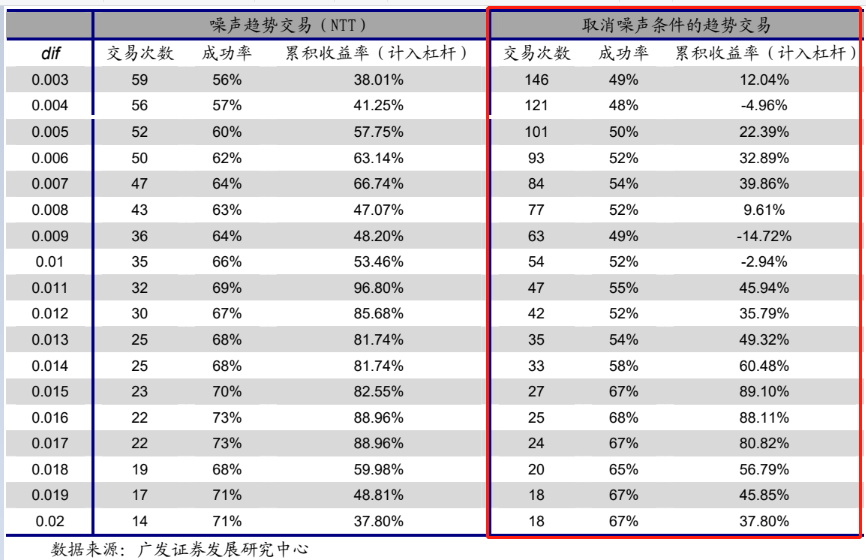

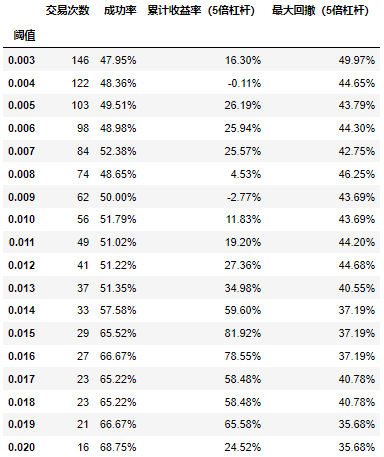

In [165]:
""" 计算收益率 """
m15_300 = calc_period_ret(m15_300, period_start='10:00:00', period_end='11:30:00')

final_df = []
for th_i in np.arange(0.003, 0.021, 0.001):
    """ 根据不同阈值th_i，循环计算信号、持仓、表现结果 """
    m15_300 = calc_period_ret_signal(m15_300, th_level=th_i)
    m15_300 = calc_position(m15_300, shift_period=1, otime_limit='11:30:00', etime_limit='15:00:00')
    # 限定样本期间
    res_m15_300, performance_df = statistic_performance(m15_300[m15_300['date']<='2011-04-15'], 
                                                        data_period=15, comm=None, leverage=5)
    """ 统计交易次数、成功率、累计收益率 """
    trade_times = performance_df.values[1][0] + performance_df.values[5][0]
    trade_win_perc = (performance_df.values[2] + performance_df.values[6])[0]/(performance_df.values[1] + performance_df.values[5])[0]
    #sum_trade_ret = res_m15_300['hold_r'].sum()
    sum_trade_ret = performance_df[0][0]
    max_dd = performance_df.values[10][0]
    """ 汇总 """
    final_df.append([th_i, trade_times, '{:.2%}'.format(trade_win_perc), sum_trade_ret, #'{:.2%}'.format(sum_trade_ret), 
                     max_dd])
final_df = pd.DataFrame(final_df, columns=['阈值', '交易次数', '成功率', '累计收益率（5倍杠杆）', '最大回撤（5倍杠杆）']).set_index('阈值')
final_df

100%|█████████████████████████████████████████████████████████████████████████████| 2868/2868 [00:08<00:00, 335.10it/s]


,交易次数,成功率,累计收益率（5倍杠杆）,最大回撤（5倍杠杆）
阈值,,,,
0.003,146,47.95%,16.30%,49.97%
0.004,122,48.36%,-0.11%,44.65%
0.005,103,49.51%,26.19%,43.79%
0.006,98,48.98%,25.94%,44.30%
0.007,84,52.38%,25.57%,42.75%
0.008,74,48.65%,4.53%,46.25%
0.009,62,50.00%,-2.77%,43.69%
0.010,56,51.79%,11.83%,43.69%
0.011,49,51.02%,19.20%,44.20%


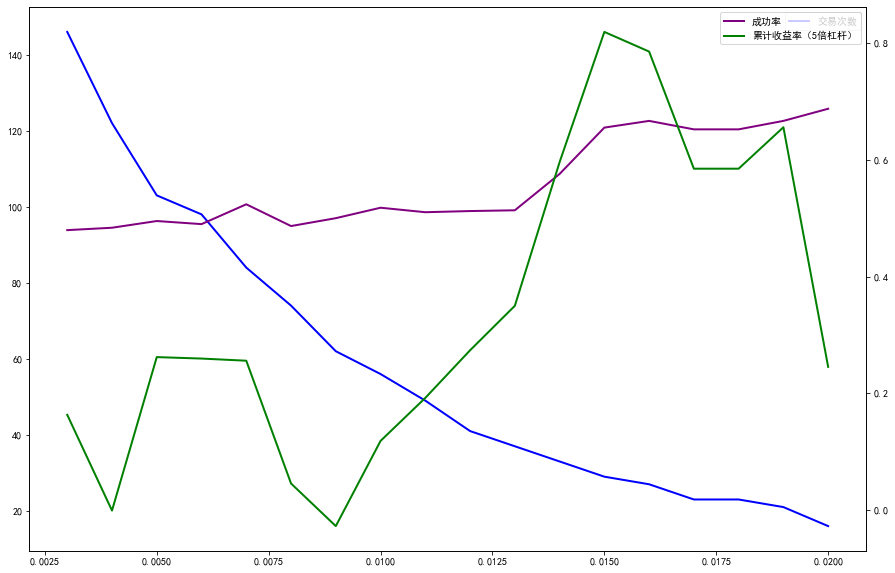

In [16]:
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt_df = final_df.copy()
plt_df['成功率'] = plt_df['成功率'].apply(lambda x: float(x[:-1])/100)
plt_df['累计收益率（5倍杠杆）'] = plt_df['累计收益率（5倍杠杆）'].apply(lambda x: float(x[:-1])/100)
plt_df['最大回撤（5倍杠杆）'] = plt_df['最大回撤（5倍杠杆）'].apply(lambda x: float(x[:-1])/100)

fig=plt.figure(figsize=(15,10))

ax1=fig.add_subplot(111)
ax1.plot(plt_df['交易次数'], '-', color='blue', label='交易次数', linewidth=2)

ax2=ax1.twinx()#这是双坐标关键一步
ax2.plot(plt_df['成功率'], '-', color='purple', label='成功率',linewidth=2)
ax2.plot(plt_df['累计收益率（5倍杠杆）'], '-', color='green', label='累计收益率（5倍杠杆）', linewidth=2)
#ax2.plot(plt_df['最大回撤（5倍杠杆）'], 'b-', linewidth=2)

ax1.legend()
ax2.legend()

plt.show()

### 多项式法-走势单边表现
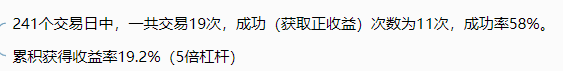

In [17]:
""" 在m1数据上进行四阶回归，计算信号赋值在m15数据上 """
m1_300 = calc_period_polyfit_d1_value(m1_300, "10:00:00", "11:30:00", 4)
m15_300 = calc_period_polyfit_signal(m15_300, m1_300, period_end="11:30:00")
m15_300 = calc_position(m15_300, shift_period=1, otime_limit='11:30:00', etime_limit='15:00:00')

""" 样本期内（2010.04.16~2011.04.15）多空信号次数 """
print(m15_300[(m15_300['date']>='2010-04-16')&(m15_300['date']<='2011-04-15')]['signal'].value_counts())
m15_300.head(135)

100%|██████████████████████████████████████████████████████████████████████████████| 2868/2868 [01:27<00:00, 32.67it/s]


 0    224
-1     10
 1      7
Name: signal, dtype: int64


,open,close,high,low,volume,money,date,time,period_ret,signal,position
0,3474.055,3466.988,3513.114,3458.142,5296.0,5.531420e+09,2010-04-16,09:30:00,None,None,0.0
1,3467.864,3469.019,3478.529,3463.725,4568.0,4.750250e+09,2010-04-16,09:45:00,None,None,0.0
2,3469.136,3470.313,3471.154,3461.714,4220.0,4.382473e+09,2010-04-16,10:00:00,None,None,0.0
3,3470.175,3464.512,3470.712,3461.889,3151.0,3.270559e+09,2010-04-16,10:15:00,None,None,0.0
4,3464.528,3453.217,3465.486,3450.437,4177.0,4.326711e+09,2010-04-16,10:30:00,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...
130,3187.954,3182.886,3189.376,3178.222,7698.0,7.322351e+09,2010-04-27,10:30:00,None,None,0.0
131,3182.968,3157.499,3186.641,3153.592,8212.0,7.786953e+09,2010-04-27,10:45:00,None,None,0.0
132,3157.347,3164.869,3167.534,3155.716,6800.0,6.424411e+09,2010-04-27,11:00:00,None,None,0.0
133,3164.747,3144.531,3166.512,3142.298,10724.0,1.010235e+10,2010-04-27,11:15:00,None,None,0.0


In [53]:
res_m15_300, performance_df = statistic_performance(m15_300[m15_300['date']<='2011-04-15'], 
                                                    data_period=15, comm=None, leverage=5)

""" 交易次数、成功率 """
trade_times = performance_df.values[1][0] + performance_df.values[5][0]
trade_win_perc = (performance_df.values[2] + performance_df.values[6])[0]/(performance_df.values[1] + performance_df.values[5])[0]

stats = [trade_times, '{:.2%}'.format(trade_win_perc)]
print(pd.DataFrame(stats, index=['交易次数', '成功率']))

""" 整体表现 """
print(performance_df)
visualize_performance(res_m15_300)

           0
交易次数      17
成功率   52.94%
                0
累计收益       12.65%
多仓次数            7
多仓成功次数          3
多仓胜率       42.86%
多仓平均持有期      7.00
空仓次数           10
空仓成功次数          6
空仓胜率       60.00%
空仓平均持有期      7.00
日胜率        50.00%
最大回撤       30.29%
年化收益/最大回撤    0.42
年化收益       12.69%
年化标准差      22.41%
年化夏普         0.57


# Part 2 增加NTS信号过滤

## 过滤信号指标计算

### NTS指标

#### 上午走势计算NTS

### 多项式拟合结果直接计算R方、信噪比
- R方： 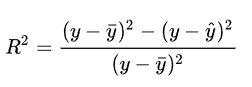
- 信噪比： 信噪比的计量单位是dB，其计算方法是10lg(Ps/Pn)，其中Ps和Pn分别代表信号和噪声的有效功率

#### 定义新指标计算函数

In [66]:
import numpy as np
import math

def calc_SNR(S, SN):
    """ 
        S: 纯信号
        SN:带噪信号
    """
    S = S-np.mean(S)# 消除直流分量
    S = S/np.max(np.abs(S))#幅值归一化
    mean_S = (np.sum(S))/(len(S))#纯信号的平均值
    PS = np.sum((S-mean_S)*(S-mean_S))
    PN = np.sum((S-SN)*(S-SN))
    snr=10*math.log((PS/PN), 10)
    return(snr)

def calc_period_polyfit_indicators(mkt_data, period_start, period_end, poly_degree):    
    """ 按日顺序计算 """
    final_dfs = []
    day_idxes = np.hstack([m1_300.drop_duplicates(subset='date').index, len(m1_300)])
    for start_idx, end_idx in zip(tqdm(day_idxes[:-1]), day_idxes[1:]):
        tmp_d_df = mkt_data.iloc[start_idx: end_idx, :].copy()
        """ 将period_start到period_end期间的close序列，按poly_degree进行拟合，并计算dydt """
        # 1. 多项式回归得到params，并通过params生成Formula
        fit_close_s = tmp_d_df[(tmp_d_df['time']>=period_start)&(tmp_d_df['time']<=period_end)]['close']
        params_n = np.polyfit(range(len(fit_close_s)), fit_close_s, poly_degree)
        # 2. Sympy求Formula的一阶导函数，然后计算全部点下的一阶导结果
        #fit_formula, t = get_formula(params_n, x_name='t')
        #fit_formula_d1 = sympy.diff(fit_formula ,t, 1)
        #d1_values = np.array([fit_formula_d1.evalf(subs={t: x}) for x in range(len(fit_close_s))])
        
        # 3. 使用np.poly1d计算d1_values
        f = np.poly1d(params_n)
        f_d1 = f.deriv(m=1)
        d1_values = np.polyval(f_d1.coef, range(len(fit_close_s)))
        
        # 计算R方
        pred_close_s = np.polyval(params_n, range(len(fit_close_s)))
        Rsquare = np.corrcoef(fit_close_s, pred_close_s)[0,1]**2
        # 计算信噪比
        SNR = calc_SNR(pred_close_s, fit_close_s)
        
        """ 指标赋值 """
        tmp_d_df['t'], tmp_d_df['d1_value'] = None, None
        tmp_d_df['t'][(tmp_d_df['time']>=period_start)&(tmp_d_df['time']<=period_end)] = range(len(fit_close_s))
        tmp_d_df['d1_value'][(tmp_d_df['time']>=period_start)&(tmp_d_df['time']<=period_end)] = d1_values

        tmp_d_df['Rsquare'] = Rsquare
        tmp_d_df['SNR'] = SNR
        """ 汇总 """
        final_dfs.append(tmp_d_df)
    """ 拼接汇总后的每日结果DataFrame """
    mkt_data = pd.concat(final_dfs)
    return mkt_data

#### 定义新持仓计算函数

In [163]:
def calc_period_polyfit_signal(mkt_data, indi_df, period_end, filter_indi=None, filter_level=None):
    final_dfs = []
    for d in tqdm(sorted(indi_df['date'].unique())):
        """ 在d1_value_df上进行信号计算 """
        tmp_indi_df = indi_df[indi_df['date']==d]
        d1_values = tmp_indi_df['d1_value'].dropna()
        # 若>0，<0的导数值都有，则存在极值，不符合条件；反之则符合，按照一阶导方向进行做多/做空
        signal = ((d1_values>0).sum()>0).astype(int) - ((d1_values<0).sum()>0).astype(int)
        # 若额外判断其他指标，在filter_indi值大于filter_level时，则原信号无效，设定为0
        if filter_indi:
            indi_value = tmp_indi_df[filter_indi].values[0]
            if indi_value>filter_level:
                signal = 0
        """ 赋值到mkt_data当日的period_end记录上 """
        tmp_mkt_data = mkt_data[mkt_data['date']==d].copy()
        tmp_mkt_data['signal'] = None
        tmp_mkt_data['signal'][tmp_mkt_data['time']==period_end] = signal
        """ 汇总 """
        final_dfs.append(tmp_mkt_data)
    """ 拼接汇总后的每日结果DataFrame """
    mkt_data = pd.concat(final_dfs)
    return mkt_data

def calc_period_ret_signal(mkt_data, th_level, indi_df=None, filter_indi=None, filter_level=None):
    """ 根据th_level，计算持仓signal """
    signal = (mkt_data['period_ret']>th_level).astype(int) - (mkt_data['period_ret']<-th_level).astype(int)
    signal[mkt_data['period_ret'].isnull()] = None
    mkt_data['signal'] = signal
    if filter_indi:
        # Sample => {date: {filter_indi: indi_value}}
        indi_dict = m1_300[['date', filter_indi]].drop_duplicates().set_index('date').to_dict(orient='index')
        mkt_data['signal'] = mkt_data['date'].apply(lambda d: 0 if indi_dict[d][filter_indi]>filter_level else 1) * mkt_data['signal']
    return mkt_data

#### 策略测试 - 原始多项式拟合策略

In [114]:
""" 在m1数据上进行四阶回归，计算指标赋值在m15数据上 """
m1_300 = calc_period_polyfit_indicators(m1_300, "10:00:00", "11:30:00", 4)

100%|█████████████████████████████████████████████████████████████████████████████| 2868/2868 [00:09<00:00, 292.13it/s]


In [128]:
""" 根据阈值设定信号 """
m15_300 = calc_period_polyfit_signal(m15_300, m1_300, '11:30:00', filter_indi=None, filter_level=None)
m15_300 = calc_position(m15_300, shift_period=1, otime_limit='11:30:00', etime_limit='15:00:00')

""" 样本期内（2010.04.16~2011.04.15）多空信号次数 """
print(m15_300[m15_300['date']<='2011-04-15']['signal'].value_counts())

""" 表现统计 """
res_m15_300, performance_df = statistic_performance(m15_300[m15_300['date']<='2011-04-15'], 
                                                    data_period=15, comm=None, leverage=5)

""" 交易次数、成功率 """
trade_times = performance_df.values[1][0] + performance_df.values[5][0]
trade_win_perc = (performance_df.values[2] + performance_df.values[6])[0]/(performance_df.values[1] + performance_df.values[5])[0]

stats = [trade_times, '{:.2%}'.format(trade_win_perc)]
print(pd.DataFrame(stats, index=['交易次数', '成功率']))

""" 整体表现 """
print(performance_df)
visualize_performance(res_m15_300)

100%|██████████████████████████████████████████████████████████████████████████████| 2868/2868 [01:21<00:00, 35.23it/s]


 0    224
-1     10
 1      7
Name: signal, dtype: int64
           0
交易次数      17
成功率   52.94%
                0
累计收益       12.65%
多仓次数            7
多仓成功次数          3
多仓胜率       42.86%
多仓平均持有期      7.00
空仓次数           10
空仓成功次数          6
空仓胜率       60.00%
空仓平均持有期      7.00
日胜率        50.00%
最大回撤       30.29%
年化收益/最大回撤    0.42
年化收益       12.69%
年化标准差      22.41%
年化夏普         0.57


#### R方与SNR的Spearman秩相关

In [129]:
import scipy.stats

In [130]:
spearman_r, p_value = scipy.stats.spearmanr(m1_300[m1_300['date']<='2011-04-15']['Rsquare'], 
                                            m1_300[m1_300['date']<='2011-04-15']['SNR'])
spearman_r

0.18714978910188265

#### 可视化R方、信噪比查看有效性，确定阈值

In [131]:
position_df = res_m15_300[(res_m15_300['date']<='2011-04-15') & (res_m15_300['position'].isin([1,-1]))]
hold_r_df = pd.pivot_table(position_df, index='date', values=['hold_r'], aggfunc=np.sum).reset_index()
res_df = pd.merge(hold_r_df, m1_300[['date', 'Rsquare', 'SNR']].drop_duplicates(), 
                  how='left', on='date').sort_values('hold_r')
res_df

,date,hold_r,Rsquare,SNR
11,2011-01-07,-0.078728,0.961895,-79.160177
14,2011-03-29,-0.075685,0.916234,-77.620983
6,2010-08-24,-0.067660,0.963459,-77.562708
2,2010-07-02,-0.046754,0.847983,-74.899623
10,2010-11-26,-0.045122,0.899321,-80.272961
16,2011-04-15,-0.041995,0.915411,-75.962768
4,2010-07-26,-0.038074,0.934959,-76.334786
9,2010-11-10,-0.031117,0.911292,-79.726204
3,2010-07-08,0.007089,0.832344,-75.708409
8,2010-09-27,0.008738,0.830221,-79.890832


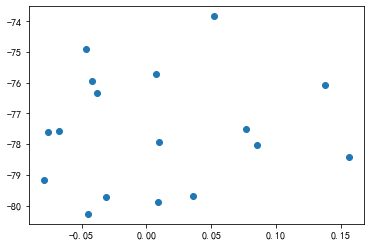

In [132]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(res_df['hold_r'], res_df['SNR'])

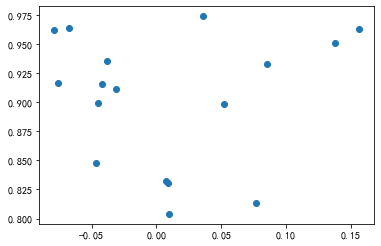

In [133]:
fig, ax = plt.subplots()
ax.scatter(res_df['hold_r'], res_df['Rsquare'])

#### 策略测试 - 多项式（SNR>-0.79)

In [151]:
""" 因为filter_indi的逻辑写的是越小越好，所以对Rsquare和SNR进行一定处理 """
m1_300['1-Rsquare'] = 1 - m1_300['Rsquare']
m1_300['-SNR'] = - m1_300['SNR']

""" 根据阈值设定信号 """
m15_300 = calc_period_polyfit_signal(m15_300, m1_300, '11:30:00', filter_indi='-SNR', filter_level=79.0)
m15_300 = calc_position(m15_300, shift_period=1, otime_limit='11:30:00', etime_limit='15:00:00')

""" 样本期内（2010.04.16~2011.04.15）多空信号次数 """
print(m15_300[m15_300['date']<='2011-04-15']['signal'].value_counts())

  7%|█████▏                                                                         | 188/2868 [00:05<01:15, 35.58it/s]

2011-01-17 78.02736620220499 79.0


100%|██████████████████████████████████████████████████████████████████████████████| 2868/2868 [01:21<00:00, 35.28it/s]


 0    229
-1      8
 1      4
Name: signal, dtype: int64


In [155]:
""" 表现统计 """
res_m15_300, performance_df = statistic_performance(m15_300[m15_300['date']<='2011-04-15'], 
                                                    data_period=15, comm=None, leverage=5)

""" 交易次数、成功率 """
trade_times = performance_df.values[1][0] + performance_df.values[5][0]
trade_win_perc = (performance_df.values[2] + performance_df.values[6])[0]/(performance_df.values[1] + performance_df.values[5])[0]

stats = [trade_times, '{:.2%}'.format(trade_win_perc)]
print(pd.DataFrame(stats, index=['交易次数', '成功率']))

""" 整体表现 """
print(performance_df)
visualize_performance(res_m15_300)

           0
交易次数      12
成功率   58.33%
                0
累计收益       26.43%
多仓次数            4
多仓成功次数          2
多仓胜率       50.00%
多仓平均持有期      7.00
空仓次数            8
空仓成功次数          5
空仓胜率       62.50%
空仓平均持有期      7.00
日胜率        53.12%
最大回撤       22.07%
年化收益/最大回撤    1.20
年化收益       26.51%
年化标准差      20.22%
年化夏普         1.31


#### 策略比对 - 收益率法 - 参数调优 （SNR>-0.79)

In [191]:
""" 计算收益率 """
m15_300 = calc_period_ret(m15_300, period_start='10:00:00', period_end='11:30:00')

""" 仅考虑阈值 """
final_df = []
for th_i in np.arange(0.003, 0.021, 0.001):
    """ 根据不同阈值th_i，循环计算信号、持仓、表现结果 """
    m15_300 = calc_period_ret_signal(m15_300, th_level=th_i)
    m15_300 = calc_position(m15_300, shift_period=1, otime_limit='11:30:00', etime_limit='15:00:00')
    # 限定样本期间
    res_m15_300, performance_df = statistic_performance(m15_300[m15_300['date']<='2011-04-15'], 
                                                        data_period=15, comm=None, leverage=5)
    """ 统计交易次数、成功率、累计收益率 """
    trade_times = performance_df.values[1][0] + performance_df.values[5][0]
    trade_win_perc = (performance_df.values[2] + performance_df.values[6])[0]/(performance_df.values[1] + performance_df.values[5])[0]
    #sum_trade_ret = res_m15_300['hold_r'].sum()
    sum_trade_ret = performance_df[0][0]
    max_dd = performance_df.values[10][0]
    """ 汇总 """
    final_df.append([th_i, trade_times, '{:.2%}'.format(trade_win_perc), sum_trade_ret, #'{:.2%}'.format(sum_trade_ret), 
                     max_dd])
final_df = pd.DataFrame(final_df, columns=['阈值', '交易次数', '成功率', '累计收益率（5倍杠杆）', '最大回撤（5倍杠杆）']).set_index('阈值')

""" 考虑阈值 + SNR>-0.79  """
final_df2 = []
for th_i in np.arange(0.003, 0.021, 0.001):
    """ 根据不同阈值th_i，循环计算信号、持仓、表现结果 """
    m15_300 = calc_period_ret_signal(m15_300, th_level=th_i, indi_df=m1_300, filter_indi='-SNR', filter_level=79.0)
    m15_300 = calc_position(m15_300, shift_period=1, otime_limit='11:30:00', etime_limit='15:00:00')
    # 限定样本期间
    res_m15_300, performance_df = statistic_performance(m15_300[m15_300['date']<='2011-04-15'], 
                                                        data_period=15, comm=None, leverage=5)
    """ 统计交易次数、成功率、累计收益率 """
    trade_times = performance_df.values[1][0] + performance_df.values[5][0]
    trade_win_perc = (performance_df.values[2] + performance_df.values[6])[0]/(performance_df.values[1] + performance_df.values[5])[0]
    #sum_trade_ret = res_m15_300['hold_r'].sum()
    sum_trade_ret = performance_df[0][0]
    max_dd = performance_df.values[10][0]
    """ 汇总 """
    final_df2.append([th_i, trade_times, '{:.2%}'.format(trade_win_perc), sum_trade_ret, #'{:.2%}'.format(sum_trade_ret), 
                     max_dd])
final_df2 = pd.DataFrame(final_df2, columns=['阈值', '交易次数', '成功率', '累计收益率（5倍杠杆）', '最大回撤（5倍杠杆）']).set_index('阈值')
final_df2

pd.concat([final_df2, final_df], axis=1)

100%|█████████████████████████████████████████████████████████████████████████████| 2868/2868 [00:08<00:00, 335.16it/s]


,交易次数,成功率,累计收益率（5倍杠杆）,最大回撤（5倍杠杆）,交易次数,成功率,累计收益率（5倍杠杆）,最大回撤（5倍杠杆）
阈值,,,,,,,,
0.003,109,50.46%,54.58%,43.44%,146,47.95%,16.30%,49.97%
0.004,92,48.91%,19.42%,43.46%,122,48.36%,-0.11%,44.65%
0.005,81,50.62%,40.44%,42.93%,103,49.51%,26.19%,43.79%
0.006,77,50.65%,44.92%,43.45%,98,48.98%,25.94%,44.30%
0.007,66,53.03%,37.72%,43.45%,84,52.38%,25.57%,42.75%
0.008,59,50.85%,25.80%,42.56%,74,48.65%,4.53%,46.25%
0.009,50,50.00%,10.12%,42.56%,62,50.00%,-2.77%,43.69%
0.010,44,52.27%,26.65%,42.56%,56,51.79%,11.83%,43.69%
0.011,40,52.50%,24.44%,42.56%,49,51.02%,19.20%,44.20%


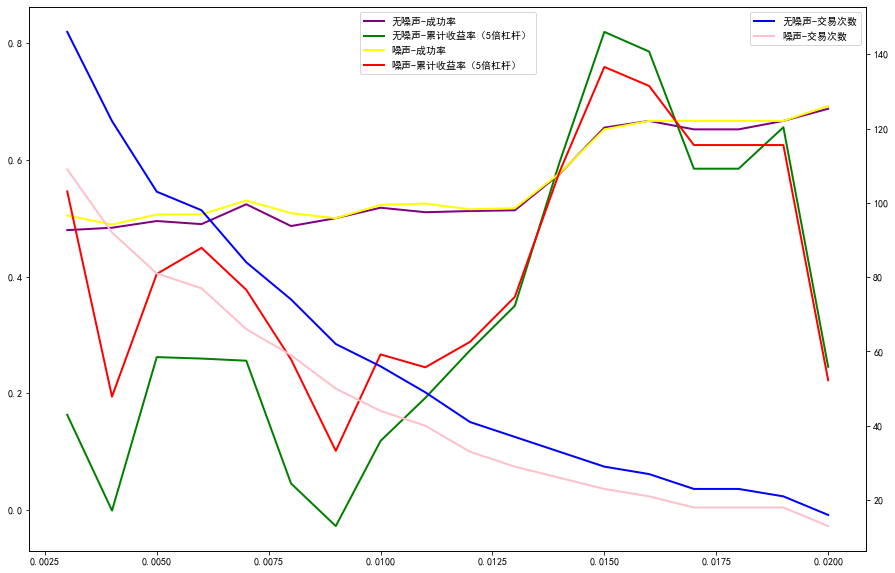

In [194]:
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt_df = final_df.copy()
plt_df['成功率'] = plt_df['成功率'].apply(lambda x: float(x[:-1])/100)
plt_df['累计收益率（5倍杠杆）'] = plt_df['累计收益率（5倍杠杆）'].apply(lambda x: float(x[:-1])/100)
plt_df['最大回撤（5倍杠杆）'] = plt_df['最大回撤（5倍杠杆）'].apply(lambda x: float(x[:-1])/100)

plt_df2 = final_df2.copy()
plt_df2['成功率'] = plt_df2['成功率'].apply(lambda x: float(x[:-1])/100)
plt_df2['累计收益率（5倍杠杆）'] = plt_df2['累计收益率（5倍杠杆）'].apply(lambda x: float(x[:-1])/100)
plt_df2['最大回撤（5倍杠杆）'] = plt_df2['最大回撤（5倍杠杆）'].apply(lambda x: float(x[:-1])/100)


fig=plt.figure(figsize=(15,10))

ax1=fig.add_subplot(111)
ax1.plot(plt_df['成功率'], '-', color='purple', label='无噪声-成功率',linewidth=2)
ax1.plot(plt_df['累计收益率（5倍杠杆）'], '-', color='green', label='无噪声-累计收益率（5倍杠杆）', linewidth=2)
ax1.plot(plt_df2['成功率'], '-', color='yellow', label='噪声-成功率',linewidth=2)
ax1.plot(plt_df2['累计收益率（5倍杠杆）'], '-', color='red', label='噪声-累计收益率（5倍杠杆）', linewidth=2)

ax2=ax1.twinx()  #这是双坐标关键一步
ax2.plot(plt_df['交易次数'], '-', color='blue', label='无噪声-交易次数', linewidth=2)
ax2.plot(plt_df2['交易次数'], '-', color='pink', label='噪声-交易次数', linewidth=2)

ax1.legend(loc='upper center')
ax2.legend(loc='upper right')

plt.show()

#### 策略比对 - 收益率法 - 平台中值（0.017）

In [195]:
th_i = 0.017

""" 仅收益率判断单边策略,阈值=0.017 """
m15_300 = calc_period_ret_signal(m15_300, th_level=th_i)
m15_300 = calc_position(m15_300, shift_period=1, otime_limit='11:30:00', etime_limit='15:00:00')
# 限定样本期间
res_m15_300, performance_df = statistic_performance(m15_300[m15_300['date']<='2011-04-15'], data_period=15, comm=None, leverage=5)

trade_times = performance_df.values[1][0] + performance_df.values[5][0]
trade_win_perc = (performance_df.values[2] + performance_df.values[6])[0]/(performance_df.values[1] + performance_df.values[5])[0]
perf_df1 = pd.concat([performance_df,
                            pd.DataFrame([trade_times, '{:.2%}'.format(trade_win_perc)], index=['交易次数', '成功率'])
                           ])

""" 单边策略基础上加入 SNR<-0.79 """
m15_300 = calc_period_ret_signal(m15_300, th_level=th_i, indi_df=m1_300, filter_indi='-SNR', filter_level=79.0)
m15_300 = calc_position(m15_300, shift_period=1, otime_limit='11:30:00', etime_limit='15:00:00')
# 限定样本期间
res_m15_300, performance_df = statistic_performance(m15_300[m15_300['date']<='2011-04-15'], data_period=15, comm=None, leverage=5)

trade_times = performance_df.values[1][0] + performance_df.values[5][0]
trade_win_perc = (performance_df.values[2] + performance_df.values[6])[0]/(performance_df.values[1] + performance_df.values[5])[0]
perf_df2 = pd.concat([performance_df, pd.DataFrame([trade_times, '{:.2%}'.format(trade_win_perc)], 
                                                         index=['交易次数', '成功率'])
                           ])

perf_comp_df = pd.concat([perf_df1, perf_df2], axis=1)
perf_comp_df.columns=['仅收益率判断单边策略,阈值=0.017', '单边策略基础上加入 SNR<-0.79']
perf_comp_df 

,"仅收益率判断单边策略,阈值=0.017",单边策略基础上加入 SNR<-0.79
累计收益,58.48%,62.53%
多仓次数,12,8
多仓成功次数,7,5
多仓胜率,58.33%,62.50%
多仓平均持有期,7.00,7.00
空仓次数,11,10
空仓成功次数,8,7
空仓胜率,72.73%,70.00%
空仓平均持有期,7.00,7.00
日胜率,55.98%,57.64%
